**Nombre:** Samuel Cortes Salazar \\
**Fecha:** 15/04/2024

# PUNTO 1: Rebote amortiguado

In [ ]:
# Librerías y constantes:

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd

# Constantes físicas del sistema:

K = 10000
Gamma = 10
g = 9.8
m = 1
R = 2
Lx = 40

# Condiciones iniciales del sistema:

N = 1
m = 1
R = 2
RMesa = 100*Lx
MMesa = 100*m
y0 = 30
Vy0 = 0

# Constantes del algoritmo PEFRL:

Xi=0.1786178958448091
Lambda=-0.2123418310626054
Chi=-0.06626458266981849
Um2lambdau2=(1-2*Lambda)/2
Um2chiplusxi=1-2*(Chi+Xi)
Gamma=-Gamma

In [ ]:
class Cuerpo:
  def __init__(self,x0,y0,z0,Vx0,Vy0,Vz0,m0,R0):
    self.m = m0
    self.r = np.array([x0,y0,z0])
    self.V = np.array([Vx0,Vy0,Vz0])
    self.R = R0
  def BorreFuerza(self):
    self.F = np.array([0.0,0.0,0.0])
  def SumeFuerza(self,dF):
    self.F = self.F+dF
  def Mueva_r(self,dt,coef):
    self.r = self.r+self.V*dt*coef
  def Mueva_V(self,dt,coef):
    self.V = self.V+self.F*coef*(dt/self.m)

In [ ]:
class Colisionador:
  def CalculeTodasLasFuerzas(self,Cuerpo,dt):
    for i in range(N+1):
      Cuerpo[i].BorreFuerza();
    for i in range(N):
      Fg = np.array([0,-Cuerpo[i].m*g,0])
      Cuerpo[i].SumeFuerza(Fg);
    for i in range(N):
      for j in range(i+1,N+1):
        self.CalculeFuerzaEntre(Cuerpo[i],Cuerpo[j],dt);
  def CalculeFuerzaEntre(self,Cuerpo,Mesa,dt):
    m = Cuerpo.m
    r21 = Cuerpo.r - Mesa.r
    r = np.linalg.norm(r21)
    R1 = Cuerpo.R;  R2 = Mesa.R
    s = (R1+R2)-r
    if s>0:
      n = np.array([0,1,0])
      t = np.array([1,0,0])
      k = np.array([0,0,1])
      Vcn = -Cuerpo.V
      aux = K*s**(1.5)-Gamma*m*np.sqrt(s)*(Vcn*n)
      FN = aux*n
      if FN[1]>0:
        Cuerpo.SumeFuerza(FN);  Mesa.SumeFuerza(FN*(-1));

In [ ]:
ttotal=10.97
dt=5.0e-3
Bola=Cuerpo(Lx/2, y0, 0, 0, Vy0, 0, m, R)
Mesa=Cuerpo(Lx/2, -RMesa, 0, 0, 0, 0, MMesa, RMesa)
Cuerpos=np.array([Bola,Mesa])
Normal=Colisionador()

In [ ]:
tiempos = np.arange(0, ttotal, dt)
df = pd.DataFrame(columns=['x1', 'y1', 'z1','x2', 'y2', 'z2'], index=tiempos)
df.index.name = 't'

for t in df.index.to_numpy():
  df.loc[t] = [Cuerpos[0].r[0], Cuerpos[0].r[1], Cuerpos[0].r[2], Cuerpos[1].r[0], Cuerpos[1].r[1], Cuerpos[1].r[2]]
  for i in range(N):
    Cuerpos[i].Mueva_r(dt,Xi)
  Normal.CalculeTodasLasFuerzas(Cuerpos,dt)
  for i in range(N):
    Cuerpos[i].Mueva_V(dt,Um2lambdau2)
  for i in range(N):
    Cuerpos[i].Mueva_r(dt,Chi)
  Normal.CalculeTodasLasFuerzas(Cuerpos,dt)
  for i in range(N):
    Cuerpos[i].Mueva_V(dt,Lambda)
  for i in range(N):
    Cuerpos[i].Mueva_r(dt,Um2chiplusxi)
  Normal.CalculeTodasLasFuerzas(Cuerpos,dt)
  for i in range(N):
    Cuerpos[i].Mueva_V(dt,Lambda)
  for i in range(N):
    Cuerpos[i].Mueva_r(dt,Chi)
  Normal.CalculeTodasLasFuerzas(Cuerpos,dt)
  for i in range(N):
    Cuerpos[i].Mueva_V(dt,Um2lambdau2)
  for i in range(N):
    Cuerpos[i].Mueva_r(dt,Xi)

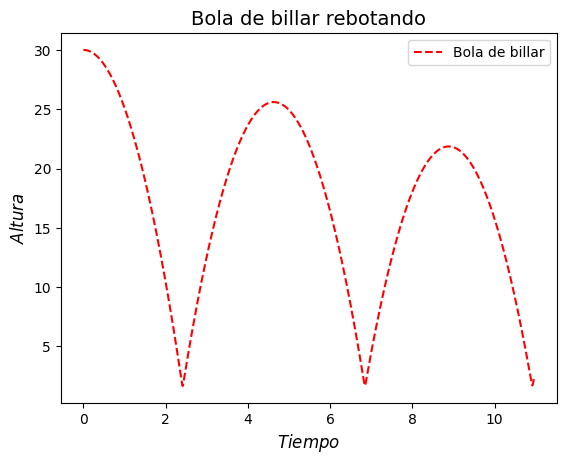

In [ ]:
plt.plot(tiempos, df['y1'], label = 'Bola de billar',linestyle='--',color='red')
plt.xlabel("$Tiempo$",size=12)
plt.ylabel("$Altura$",size=12)
plt.title("Bola de billar rebotando",size=14)
plt.savefig("BolaBillarRebotando.jpg")
plt.legend()

Para establecer el *Δt*, fui tanteando valores a diferentes ordenes de magnitud. Noté que desde 1.0e-3, el código compilaba bien, sin embargo establecí como valor óptimo *Δt=5.0e-3*, para que así el código no demorase tanto en compilar. 🐱 \\
Por otro lado, el tiempo *T_{rebote}* que estimé a simple vista (con γ=0), es de *T_{rebote} = 5.1*. Consideré el primer rebote en el tiempo *t_1=2.2*, mientras que para el segundo rebote consideré *t_2=7.3* e hice *T_{rebote} = t_2 - t_1*.

IndexError: list index out of range

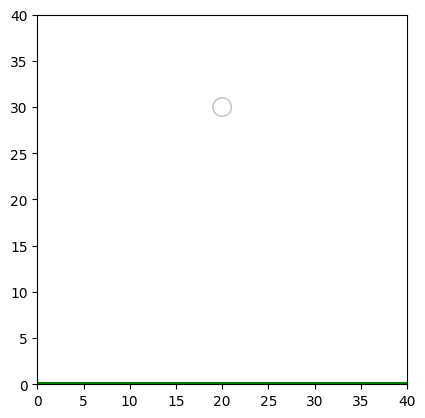

In [ ]:
from matplotlib.patches import Circle

Nsteps=6000
dist = df['x1'].tolist()
alturas = df['y1'].tolist()
fig = plt.figure()
ax = plt.axes(xlim=(0,Lx), ylim=(0.0,40.0))
ax.set_aspect('equal')
circle = Circle((Lx/2, y0), 1, color='gray', alpha=0.5, fill=False)
ax.add_patch(circle)
line_ref = ax.axhline(y=0.1, color='green', linestyle='-')
def init():
    circle.center = (Lx/2, y0)
    return circle,
def animate(i):
  x=dist[i]
  y=alturas[i]
  circle.center = (x, y)
  return circle,
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=Nsteps, interval=60, blit=False)
anim.save('BolaBillarRebotando.mp4', fps=200)

# AL COMPILAR, SALE UN ERROR DE INDEXACIÓN QUE NO LOGRÉ SOLUCIONAR. SIN EMBARGO, LA ANIMACIÓN SÍ SE GENERA Y SE GUARDA SIN NINGÚN INCONVENIENTE

# PUNTO 2: Deslizamiento

In [ ]:
# Librerías y constantes:

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd

# Constantes físicas del sistema:

K = 10000
Gamma = 10
g = 9.8
m = 1
R = 2
Lx = 40
Vx0 = 10
Omega = 3
Mu_k = 0.3
ERR = 1.0e-3
Kcundall = 500

# Condiciones iniciales del sistema:

N = 1
m = 1
R = 2
RMesa = 100*Lx
MMesa = 100*m
y0 = 0
Vy0 = 0
xCundall = np.empty((N+1,N+1))
sold = np.empty((N+1,N+1))

# Constantes del algoritmo PEFRL:

Xi=0.1786178958448091
Lambda=-0.2123418310626054
Chi=-0.06626458266981849
Um2lambdau2=(1-2*Lambda)/2
Um2chiplusxi=1-2*(Chi+Xi)
Gamma=-Gamma

In [59]:
class Cuerpo:
  def __init__(self,x0,y0,z0,Vx0,Vy0,Vz0,theta0,omega0,m0,R0):
    self.m = m0
    self.r = np.array([x0,y0,z0])
    self.V = np.array([Vx0,Vy0,Vz0])
    self.R = R0
    self.theta = theta0
    self.Omega = np.array([0,-omega0,0])
    # Definimos el momento de inercia de la bola
    self.I = (2.0/5.0)*self.m*self.R**2
  def BorreFuerza(self):
    self.F = np.array([0.0,0.0,0.0])
    self.tau = 0
  def SumeFuerza(self,dF,dtau):
    self.F = self.F+dF
    self.tau = self.tau+dtau
  def Mueva_r(self,dt,coef):
    self.r = self.r+self.V*dt*coef
    self.theta = self.theta + self.Omega[1]*dt*coef
  def Mueva_V(self,dt,coef):
    self.V = self.V+self.F*coef*(dt/self.m)
    Delta_Omega = np.array([0,self.tau*coef*dt/self.I,0])
    self.Omega = self.Omega + Delta_Omega

In [60]:
class Colisionador:
  def __init__(self):
    self.xCundall = np.zeros((N+1,N+1))
    self.sold = np.zeros((N+1,N+1))
  def Inicie(self):
    pass
  def CalculeTodasLasFuerzas(self,Cuerpo,dt):
    for i in range(N+1):
      Cuerpo[i].BorreFuerza();
    Fg = np.array([0,-Cuerpo[i].m*g,0])
    for i in range(N):
      Cuerpo[i].SumeFuerza(Fg,0);
    for i in range(N):
      for j in range(i+1,N+1):
        self.CalculeFuerzaEntre(Cuerpo[i],Cuerpo[j],dt);
  def CalculeFuerzaEntre(self,Cuerpo,Mesa,dt):
    m = Cuerpo.m
    r21 = Cuerpo.r - Mesa.r
    r = np.linalg.norm(r21)
    R1 = Cuerpo.R;  R2 = Mesa.R
    s = (R1+R2)-r
    Omega = Cuerpo.Omega[1]
    i = Cuerpos.index(Cuerpo)
    j = Cuerpos.index(Mesa)
    if s>0:
      n = np.array([0,1,0])
      t = np.array([1,0,0])
      k = np.array([0,0,1])
      Rw = R1*Omega*k
      Vc = Cuerpo.V-np.cross(Rw,n)
      Vcn = (Vc@n)*n
      Vct = Vc-Vcn
      auxn = K*s**(1.5)-Gamma*m*np.sqrt(s)*(Vcn@n)
      FN = auxn*n
      xCundall = self.xCundall[i][j]
      auxt = -Kcundall*xCundall
      Ftmax = Mu_k*abs(auxn)
      if np.abs(auxt)>Ftmax:
        auxt = auxt/(abs(auxt))*Ftmax
      FT = auxt*t
      if FN[1]>0:
        FC = FN+FT
        FM = (-1)*FC
        tauC = np.cross(-R2*n,FC)
        tauM = np.cross(FM,R1*n)
        Cuerpo.SumeFuerza(FC,tauC*k);  Mesa.SumeFuerza(FN*(-1),tauM*k);
    if self.sold[i][j]>=0 and s<0:
      self.xCundall[i][j] = 0
    self.sold[i][j] = s

In [61]:
ttotal=10.97
dt=5.0e-3
Bola=Cuerpo(0, y0, 0, Vx0, Vy0, 0, 0, Omega, m, R)
Mesa=Cuerpo(0, -RMesa, 0, 0, 0, 0, 0, 0, MMesa, RMesa)
Cuerpos=[Bola,Mesa]
Normal=Colisionador()

In [62]:
tiempos = np.arange(0, ttotal, dt)
df = pd.DataFrame(columns=['Vx', 'Vw', 'Vc'], index=tiempos)
df.index.name = 't'

for t in df.index.to_numpy():
  d = np.linalg.norm(Cuerpos[0].r-Cuerpos[1].r)
  R1 = Cuerpos[0].R
  R2 = Cuerpos[1].R
  s = (R1+R2)-d
  omega_R_prima = Cuerpos[0].Omega[1] * (Cuerpos[0].R - s)
  Vc = Cuerpos[0].V[0] - omega_R_prima
  df.loc[t] = [Cuerpos[0].V[0], omega_R_prima, Vc]
  for i in range(N):
    Cuerpos[i].Mueva_r(dt,Xi)
  Normal.CalculeTodasLasFuerzas(Cuerpos,dt)
  for i in range(N):
    Cuerpos[i].Mueva_V(dt,Um2lambdau2)
  for i in range(N):
    Cuerpos[i].Mueva_r(dt,Chi)
  Normal.CalculeTodasLasFuerzas(Cuerpos,dt)
  for i in range(N):
    Cuerpos[i].Mueva_V(dt,Lambda)
  for i in range(N):
    Cuerpos[i].Mueva_r(dt,Um2chiplusxi)
  Normal.CalculeTodasLasFuerzas(Cuerpos,dt)
  for i in range(N):
    Cuerpos[i].Mueva_V(dt,Lambda)
  for i in range(N):
    Cuerpos[i].Mueva_r(dt,Chi)
  Normal.CalculeTodasLasFuerzas(Cuerpos,dt)
  for i in range(N):
    Cuerpos[i].Mueva_V(dt,Um2lambdau2)
  for i in range(N):
    Cuerpos[i].Mueva_r(dt,Xi)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

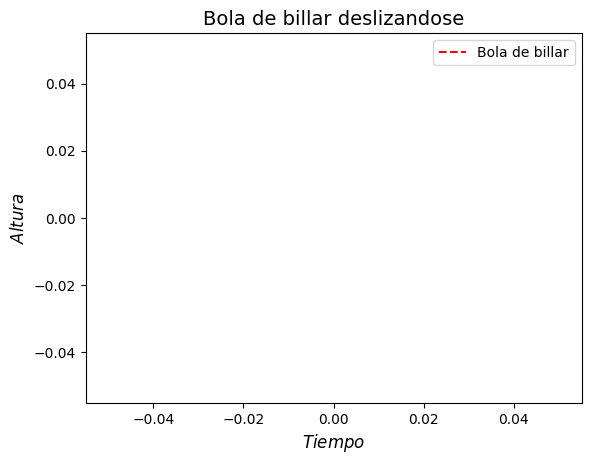

In [ ]:
plt.plot(tiempos, df['Vx'], label = 'Bola de billar',linestyle='--',color='red')
plt.xlabel("$Tiempo$",size=12)
plt.ylabel("$Altura$",size=12)
plt.title("Bola de billar deslizandose",size=14)
plt.savefig("BolaBillarDeslizando.jpg")
plt.legend()

In [ ]:
from matplotlib.patches import Circle

Nsteps=6000
dist = df['x1'].tolist()
alturas = df['y1'].tolist()
fig = plt.figure()
ax = plt.axes(xlim=(0,Lx), ylim=(0.0,40.0))
ax.set_aspect('equal')
circle = Circle((0, y0), 1, color='gray', alpha=0.5, fill=False)
ax.add_patch(circle)
line_ref = ax.axhline(y=0.1, color='green', linestyle='-')
def init():
    circle.center = (0, y0)
    return circle,
def animate(i):
  x=dist[i]
  y=alturas[i]
  circle.center = (x, y)
  return circle,
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=Nsteps, interval=60, blit=False)
anim.save('BolaBillarDeslizando.mp4', fps=200)

# AL COMPILAR, SALE UN ERROR DE INDEXACIÓN QUE NO LOGRÉ SOLUCIONAR. SIN EMBARGO, LA ANIMACIÓN SÍ SE GENERA Y SE GUARDA SIN NINGÚN INCONVENIENTE

KeyError: 'x1'

# PUNTO 3: Rodadura